In [1]:
from __future__ import division
from sympy import *
from sympy.vector import CoordSys3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D

# x, y, z, t = symbols('x y z t')
# theta, phi, Phi, Rho, alpha, beta, omega = symbols('theta, phi, Phi,Rho alpha, beta, omega')
mu, nu, rho, theta, phi, sigma, tau, a, t, x, y, z, w = symbols("mu, nu, rho, theta, phi, sigma, tau, a, t, x, y, z, w")
k, m, n = symbols('k m n', integer=True)
f, g, h = symbols('f g h', cls=Function)
init_printing()

In [2]:
P = CoordSys3D('P', transformation='spherical', variable_names=list('rtp'))
P.r
P.t

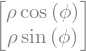

In [3]:
Matrix([[1, 2, 3], [4, 5, 6]])
M = Matrix([rho*cos(phi), rho*sin(phi)])
M

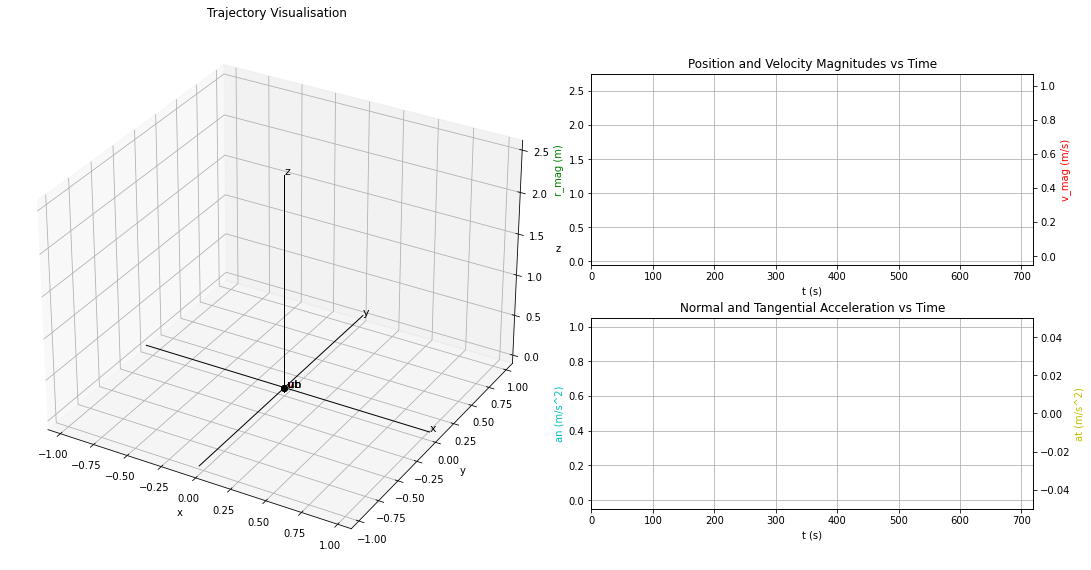

NameError: name 'vector_arrow_3d' is not defined

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.text import Annotation
from matplotlib.patches import FancyArrowPatch




class Annotation3D(Annotation):

    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0, 0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, self.axes.M)
        self.xy = (x2, y2)
        super().draw(renderer)

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

def _annotate3D(ax, text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation = Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

setattr(Axes3D, 'annotate3D', _annotate3D)


def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)



import os
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import animation


# ==============================
# vector equations

def vector_derivative(vector, wrt):
    """
    differentiate vector components wrt a symbolic variable
    param v: vector to differentiate
    param wrt: symbolic variable
    return V: velcoity vector and components in x, y, z
    """
    return [component.diff(wrt) for component in vector]


def vector_magnitude(vector):
    """
    compute magnitude of a vector
    param vector: vector with components of Cartesian form
    return magnitude: magnitude of vector
    """
    # NOTE: np.linalg.norm(v) computes Euclidean norm
    magnitude = 0
    for component in vector:
        magnitude += component ** 2
    return magnitude ** (1 / 2)


def unit_vector(from_vector_and_magnitude=None, from_othogonal_vectors=None, from_orthogonal_unit_vectors=None):
    """
    Calculate a unit vector using one of three input parameters.
    1. using vector and vector magnitude
    2. using orthogonal vectors
    3. using orthogonal unit vectors
    """

    if from_vector_and_magnitude is not None:
        vector_a, magnitude = from_vector_and_magnitude[0], from_vector_and_magnitude[1]
        return [component / magnitude for component in vector_a]

    if from_othogonal_vectors is not None:
        vector_a, vector_b = from_othogonal_vectors[0], from_othogonal_vectors[1]
        vector_normal = np.cross(vector_a, vector_b)
        return unit_vector(from_vector_and_magnitude=(vector_normal, vector_magnitude(vector_normal)))

    if from_orthogonal_unit_vectors is not None:
        u1, u2 = from_orthogonal_unit_vectors[0], from_orthogonal_unit_vectors[1]
        return np.cross(u1, u2)


def evaluate_vector(vector, time_step):
    """
    evaluate numerical vector components and magnitude @ti
    param numerical_vector: symbolic vector expression to evaluate @ti
    param ti: time step for evaluation
    return magnitude, numerical_vector: magnitude of vector and components evaluated @ti
    """
    numerical_vector = [float(component.subs(t, time_step).evalf()) for component in vector]
    magnitude = vector_magnitude(numerical_vector)
    return numerical_vector, magnitude


def direction_angles(vector, magnitude=None):
    """
    compute direction angles a vector makes with +x,y,z axes
    param vector: vector with x, y, z components
    param magnitude: magnitude of vector
    """
    magnitude = vector_magnitude(vector) if magnitude is None else magnitude
    return [sp.acos(component / magnitude) for component in vector]


# ==============================
# helper functions


def d2r(degrees):
    """
    convert from degrees to radians
    return: radians
    """
    return degrees * (np.pi / 180)


def r2d(radians):
    """
    convert from radians to degrees
    return: degrees
    """
    return radians * (180 / np.pi)


# =======================================
# simulation harness

# initial time
t0 = 0

# end time
tf = 720

# change in time
dt = 1

# time array
time = np.arange(t0, tf, dt, dtype='float')

# =======================================
# symbolic equations of motion

# Define symbolic variable t
t = sp.symbols('t')

# [x(t), y(t), z(t)] position as function of time
# R = [sp.sin(3 * t), sp.cos(t), sp.cos(2 * t)]
R = [sp.cos(t), sp.sin(t), t / 5]  # Helix: z=t
# R = [sp.cos(t), sp.sin(t), 0 * t]  # Circle: z=0*t

# velocity = dR/dt
V = vector_derivative(R, t)

# acceleration = dV/dt
A = vector_derivative(V, t)

# tangential acceleration = dV/dt (derivative of the magnitude of velocity)
At = vector_magnitude(V).diff(t)

# =======================================
# propogate system through time

propogration_time_history = []

for ti in time:
    ti_r = d2r(ti)

    # evaluate position
    r, r_mag = evaluate_vector(R, ti_r)

    # evaluate velocity
    v, v_mag = evaluate_vector(V, ti_r)

    # evaluate acceleration
    a, a_mag = evaluate_vector(A, ti_r)

    # velocity direction angles
    v_theta = [r2d(angle) for angle in direction_angles(v, v_mag)]

    # acceleration direction angles
    a_theta = [r2d(angle) for angle in direction_angles(a, a_mag)]

    # unit vector tanjent to trajectory
    ut = unit_vector(from_vector_and_magnitude=(v, v_mag))

    # unit binormal
    ub = unit_vector(from_othogonal_vectors=(v, a))

    # unit normal
    un = unit_vector(from_orthogonal_unit_vectors=(ub, ut))

    # tangential acceleration magnitude
    at = float(At.subs(t, ti_r).evalf())

    # normal acceleration
    an = np.dot(a, un)

    # radius of curvature
    rho = v_mag ** 2 / an

    # position vector of the center of curvature
    rc = r + (rho * un)

    # magnitude of the position vector of the center of curvature
    rc_mag = vector_magnitude(rc)

    iteration_results = {'t': ti, 'rx': r[0], 'ry': r[1], 'rz': r[2], 'r_mag': r_mag,
                         'vx': v[0], 'vy': v[1], 'vz': v[2], 'v_mag': v_mag,
                         'rcx': rc[0], 'rcy': rc[1], 'rcz': rc[2], 'rc_mag': rc_mag, 'rho': rho,
                         'ax': a[0], 'ay': a[1], 'az': a[2], 'a_mag': a_mag, 'an': an, 'at': at,
                         'ubx': ub[0], 'uby': ub[1], 'ubz': ub[2],
                         'utx': ut[0], 'uty': ut[1], 'utz': ut[2],
                         'unx': un[0], 'uny': un[1], 'unz': un[2]}

    propogration_time_history.append(iteration_results)

df = pd.DataFrame(propogration_time_history)

# ==============================
# run configuration

database_directory = './results/'
database_name = 'orbit'
table_name = 'orbit'

animation_directory = './animations/'
os.makedirs(animation_directory, exist_ok=True)


# =======================================
# visualise trajectory
'''
def vector_arrow_3d(x0, x1, y0, y1, z0, z1, color):
    """
    method to create a new arrow in 3d for vectors
    return Arrow3D: new vector
    """
    return Arrow3D([x0, x1], [y0, y1], [z0, z1],
                   mutation_scale=10, lw=1,
                   arrowstyle='-|>', color=color)
'''

class Animator:

    def __init__(self, simulation_results):
        self.simulation_results = simulation_results
        self.vector_lines = []
        # =======================================
        #  configure plots and data structures

        self.fig = plt.figure(figsize=(15, 8))
        self.fig.subplots_adjust(left=0.05,
                                 bottom=None,
                                 right=0.95,
                                 top=None,
                                 wspace=None,
                                 hspace=0.28)

        gs = gridspec.GridSpec(2, 2)

        self.ax1 = self.fig.add_subplot(gs[:, 0], projection='3d')
        self.ax2 = self.fig.add_subplot(gs[0, 1])
        self.ax3 = self.ax2.twinx()
        self.ax4 = self.fig.add_subplot(gs[1, 1])
        self.ax5 = self.ax4.twinx()

        self.set_axes_limits()

        # axis 1 - 3D visualisation

        self.trajectory, = self.ax1.plot([], [], [], 'bo', markersize=1)
        self.center_of_curvature, = self.ax1.plot([], [], [], 'mo', markersize=2)

        self.pos_text = self.text_artist_3d(' r', 'g')
        self.coc_text = self.text_artist_3d(' c', 'm')
        self.vel_text = self.text_artist_3d(' v', 'r')
        self.un_text = self.text_artist_3d(' un', 'k')
        self.ub_text = self.text_artist_3d(' ub', 'k')
        self.ut_text = self.text_artist_3d(' ut', 'k')

        # axis 2, 3 - position and velocity magnitudes vs time

        self.rvt, = self.ax2.plot([], [], 'g-')
        self.vvt, = self.ax3.plot([], [], 'r-')

        self.rmag_text = self.ax2.text(0, 0, '', size=12, color='g')

        # axis 4, 5 - normal and tangential acceleration vs time

        self.ant, = self.ax4.plot([], [], 'c-')
        self.att, = self.ax5.plot([], [], 'y-')

    def draw_xyz_axis(self, x_lims, y_lims, z_lims):
        """
        draw xyz axis on ax1 3d plot
        param x_lims: upper and lower x limits
        param y_lims: upper and lower y limits
        param z_lims: upper and lower z limits
        """
        self.ax1.plot([0, 0], [0, 0], [0, 0], 'ko', label='Origin')
        self.ax1.plot(x_lims, [0, 0], [0, 0], 'k-', lw=1)
        self.ax1.plot([0, 0], y_lims, [0, 0], 'k-', lw=1)
        self.ax1.plot([0, 0], [0, 0], z_lims, 'k-', lw=1)
        self.text_artist_3d('x', 'k', x_lims[1], 0, 0)
        self.text_artist_3d('y', 'k', 0, y_lims[1], 0)
        self.text_artist_3d('z', 'k', 0, 0, z_lims[1])
        self.ax1.set_xlabel('x')
        self.ax1.set_ylabel('y')
        self.ax1.set_zlabel('z')

    def text_artist_3d(self, text, color, x=0, y=0, z=0):
        """
        create new text artist for the plot
        param txt: text string
        param color: text color
        param x: x coordinate of text
        param y: y coordinate of text
        param z: z coordinate of text
        """
        return self.ax1.text(x, y, z, text, size=11, color=color)

    def set_axes_limits(self):
        """
        set the axis limits for each plot, label axes
        """
        lim_params = ['r', 'v', 'rc']
        x_lims = self.get_limits(lim_params, 'x')
        y_lims = self.get_limits(lim_params, 'y')
        z_lims = self.get_limits(lim_params, 'z')
        self.ax1.set_xlim3d(x_lims)
        self.ax1.set_ylim3d(y_lims)
        self.ax1.set_zlim3d(z_lims)
        self.draw_xyz_axis(x_lims, y_lims, z_lims)

        t_lims = self.get_limits(['t'], '')

        self.ax2.set_xlim(t_lims)
        self.ax2.set_ylim(self.get_limits(['r_mag'], ''))
        self.ax2.set_xlabel('t (s)')
        self.ax2.set_ylabel('r_mag (m)', color='g')

        self.ax3.set_ylim(self.get_limits(['v_mag'], ''))
        self.ax3.set_ylabel('v_mag (m/s)', color='r')

        self.ax4.set_xlim(t_lims)
        self.ax4.set_ylim(self.get_limits(['an'], ''))
        self.ax4.set_xlabel('t (s)')
        self.ax4.set_ylabel('an (m/s^2)', color='c')
        self.ax5.set_ylim(self.get_limits(['at'], ''))
        self.ax5.set_ylabel('at (m/s^2)', color='y')

    def get_limits(self, params, axis):
        """
        get upper and lower limits for parameter
        param axis: get limits for axis, i.e x or y
        param params: list of varaible names
        """
        lower_lim, upper_lim = 0, 0
        for p in params:
            m = max(self.simulation_results['%s%s' % (p, axis)])
            if m > upper_lim:
                upper_lim = m
            m = min(self.simulation_results['%s%s' % (p, axis)])
            if m < lower_lim:
                lower_lim = m
        return lower_lim - 0.05, upper_lim + 0.05

    def config_plots(self):
        """
        Setting the axes properties such as title, limits, labels
        """
        self.ax1.set_title('Trajectory Visualisation')
        self.ax2.set_title('Position and Velocity Magnitudes vs Time')
        self.ax4.set_title('Normal and Tangential Acceleration vs Time')
        self.ax1.set_position([0, 0, 0.5, 1])
        self.ax1.set_aspect('auto')
        self.ax2.grid()
        self.ax4.grid()

    def visualize(self, i):

        # ######
        # axis 1
        row = self.simulation_results.iloc[i]

        # define vectors
        vectors = [vector_arrow_3d(0, row.rx, 0, row.ry, 0, row.rz, 'g'),
                   vector_arrow_3d(row.rx, row.rx + row.vx, row.ry, row.ry + row.vy, row.rz, row.rz + row.vz, 'r'),
                   vector_arrow_3d(row.rx, row.rx + row.ubx, row.ry, row.ry + row.uby, row.rz, row.rz + row.ubz, 'k'),
                   vector_arrow_3d(row.rx, row.rx + row.utx, row.ry, row.ry + row.uty, row.rz, row.rz + row.utz, 'k'),
                   vector_arrow_3d(row.rx, row.rx + row.unx, row.ry, row.ry + row.uny, row.rz, row.rz + row.unz, 'k'),
                   vector_arrow_3d(row.rcx, row.rx, row.rcy, row.ry, row.rcz, row.rz, 'm')]

        # add vectors to figure
        [self.ax1.add_artist(vector) for vector in vectors]

        # remove previous vectors from figure
        if self.vector_lines:
            [vector.remove() for vector in self.vector_lines]
        self.vector_lines = vectors

        # update label text and position
        self.pos_text.set_position((row.rx, row.ry))
        self.pos_text.set_3d_properties(row.rz, 'x')

        self.coc_text.set_position((row.rcx, row.rcy))
        self.coc_text.set_3d_properties(row.rcz, 'x')

        self.vel_text.set_position((row.rx + row.vx, row.ry + row.vy))
        self.vel_text.set_3d_properties(row.rz + row.vz, 'x')

        self.un_text.set_position((row.rx + row.unx, row.ry + row.uny))
        self.un_text.set_3d_properties(row.rz + row.unz, 'x')

        self.ub_text.set_position((row.rx + row.ubx, row.ry + row.uby))
        self.ub_text.set_3d_properties(row.rz + row.ubz, 'x')

        self.ut_text.set_position((row.rx + row.utx, row.ry + row.uty))
        self.ut_text.set_3d_properties(row.rz + row.utz, 'x')

        # update trajectory for current time step
        self.trajectory.set_data(self.simulation_results['rx'][:i], self.simulation_results['ry'][:i])
        self.trajectory.set_3d_properties(self.simulation_results['rz'][:i])

        # update center of curvature for current time step
        self.center_of_curvature.set_data(self.simulation_results['rcx'][i], self.simulation_results['rcy'][i])
        self.center_of_curvature.set_3d_properties(self.simulation_results['rcz'][i])

        # update position magnitude text position
        self.rmag_text.set_position((self.simulation_results['t'][i], self.simulation_results['r_mag'][i]))
        self.rmag_text.set_text(f"{round(self.simulation_results['r_mag'][i], 2)}")

        # ######
        # axis 2

        time_step = self.simulation_results['t'][:i]

        # magnitude of position vs time
        self.rvt.set_data(time_step, self.simulation_results['r_mag'][:i])

        # magnitude of velocity vs time
        self.vvt.set_data(time_step, self.simulation_results['v_mag'][:i])

        # ######
        # axis 3

        self.ant.set_data(time_step, self.simulation_results['an'][:i])
        self.att.set_data(time_step, self.simulation_results['at'][:i])

        # plt.pause(0.05)

    def animate(self):
        """
        animate drawing velocity vector as particle
        moves along trajectory
        return: animation
        """
        return animation.FuncAnimation(self.fig,
                                       self.visualize,
                                       frames=len(time),
                                       init_func=self.config_plots(),
                                       blit=False,
                                       repeat=False,
                                       interval=2)


# =======================================
# save trajectory animation

animator = Animator(simulation_results=df)
anim = animator.animate()
plt.show()

os.makedirs('./animations', exist_ok=True)
FFwriter = animation.FFMpegWriter(fps=30)
anim.save('./animations/spiral_trajectory.gif', writer=FFwriter)

